In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("RadioFrequency").getOrCreate()

In [6]:
path = "weather_analysis.csv"
df = spark.read.csv(path, inferSchema=True, header=True)
df.show()

+-------------------+---------+---------------+----------+---------+------------+-----------+---------------+-----------+--------+----------+------------------+-----------------+-----------------+-------------+------------+---------+------------+-------------+----------+-----------+---------+---------+-----------+------------+--------------------+--------------------+
|          Timestamp|Frequency|Signal Strength|Modulation|Bandwidth|    Location|Device Type|   Antenna Type|Temperature|Humidity|Wind Speed|     Precipitation|Weather Condition|Interference Type|Battery Level|Power Source|CPU Usage|Memory Usage|WiFi Strength|Disk Usage|System Load| Latitude|Longitude|Altitude(m)|Air Pressure|       Device Status|            I/Q Data|
+-------------------+---------+---------------+----------+---------+------------+-----------+---------------+-----------+--------+----------+------------------+-----------------+-----------------+-------------+------------+---------+------------+------------

In [7]:
df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- Signal Strength: integer (nullable = true)
 |-- Modulation: string (nullable = true)
 |-- Bandwidth: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Device Type: string (nullable = true)
 |-- Antenna Type: string (nullable = true)
 |-- Temperature: integer (nullable = true)
 |-- Humidity: integer (nullable = true)
 |-- Wind Speed: integer (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Weather Condition: string (nullable = true)
 |-- Interference Type: string (nullable = true)
 |-- Battery Level: double (nullable = true)
 |-- Power Source: boolean (nullable = true)
 |-- CPU Usage: double (nullable = true)
 |-- Memory Usage: double (nullable = true)
 |-- WiFi Strength: integer (nullable = true)
 |-- Disk Usage: double (nullable = true)
 |-- System Load: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = t

In [8]:
df.describe().show()

+-------+-------------------+--------------------+------------------+----------+------------------+------------+-----------+------------+------------------+------------------+-----------------+--------------------+-----------------+-----------------+--------------------+------------------+------------------+-----------------+----------+------------------+------------------+--------------------+--------------------+------------+--------------------+--------------------+
|summary|          Timestamp|           Frequency|   Signal Strength|Modulation|         Bandwidth|    Location|Device Type|Antenna Type|       Temperature|          Humidity|       Wind Speed|       Precipitation|Weather Condition|Interference Type|       Battery Level|         CPU Usage|      Memory Usage|    WiFi Strength|Disk Usage|       System Load|          Latitude|           Longitude|         Altitude(m)|Air Pressure|       Device Status|            I/Q Data|
+-------+-------------------+--------------------+--

In [9]:
from pyspark.sql.functions import col

columns = df.columns

column_info = [
    (
        column,
        str(df.schema[column].dataType),
        df.filter(col(column).isNull()).count(),
        df.select(column).distinct().count()
    )
    for column in columns
]

result_df = spark.createDataFrame(column_info, ["Column", "Data Type", "Null Count", "Unique Count"])

result_df.show(result_df.count(),truncate=False)


+-----------------+-----------+----------+------------+
|Column           |Data Type  |Null Count|Unique Count|
+-----------------+-----------+----------+------------+
|Timestamp        |StringType |0         |164160      |
|Frequency        |IntegerType|0         |6           |
|Signal Strength  |IntegerType|0         |101         |
|Modulation       |StringType |0         |6           |
|Bandwidth        |IntegerType|0         |6           |
|Location         |StringType |0         |1           |
|Device Type      |StringType |0         |3           |
|Antenna Type     |StringType |0         |4           |
|Temperature      |IntegerType|0         |21          |
|Humidity         |IntegerType|0         |61          |
|Wind Speed       |IntegerType|0         |21          |
|Precipitation    |DoubleType |0         |164160      |
|Weather Condition|StringType |0         |3           |
|Interference Type|StringType |0         |4           |
|Battery Level    |DoubleType |0         |1     

In [10]:
print(columns)

['Timestamp', 'Frequency', 'Signal Strength', 'Modulation', 'Bandwidth', 'Location', 'Device Type', 'Antenna Type', 'Temperature', 'Humidity', 'Wind Speed', 'Precipitation', 'Weather Condition', 'Interference Type', 'Battery Level', 'Power Source', 'CPU Usage', 'Memory Usage', 'WiFi Strength', 'Disk Usage', 'System Load', 'Latitude', 'Longitude', 'Altitude(m)', 'Air Pressure', 'Device Status', 'I/Q Data']


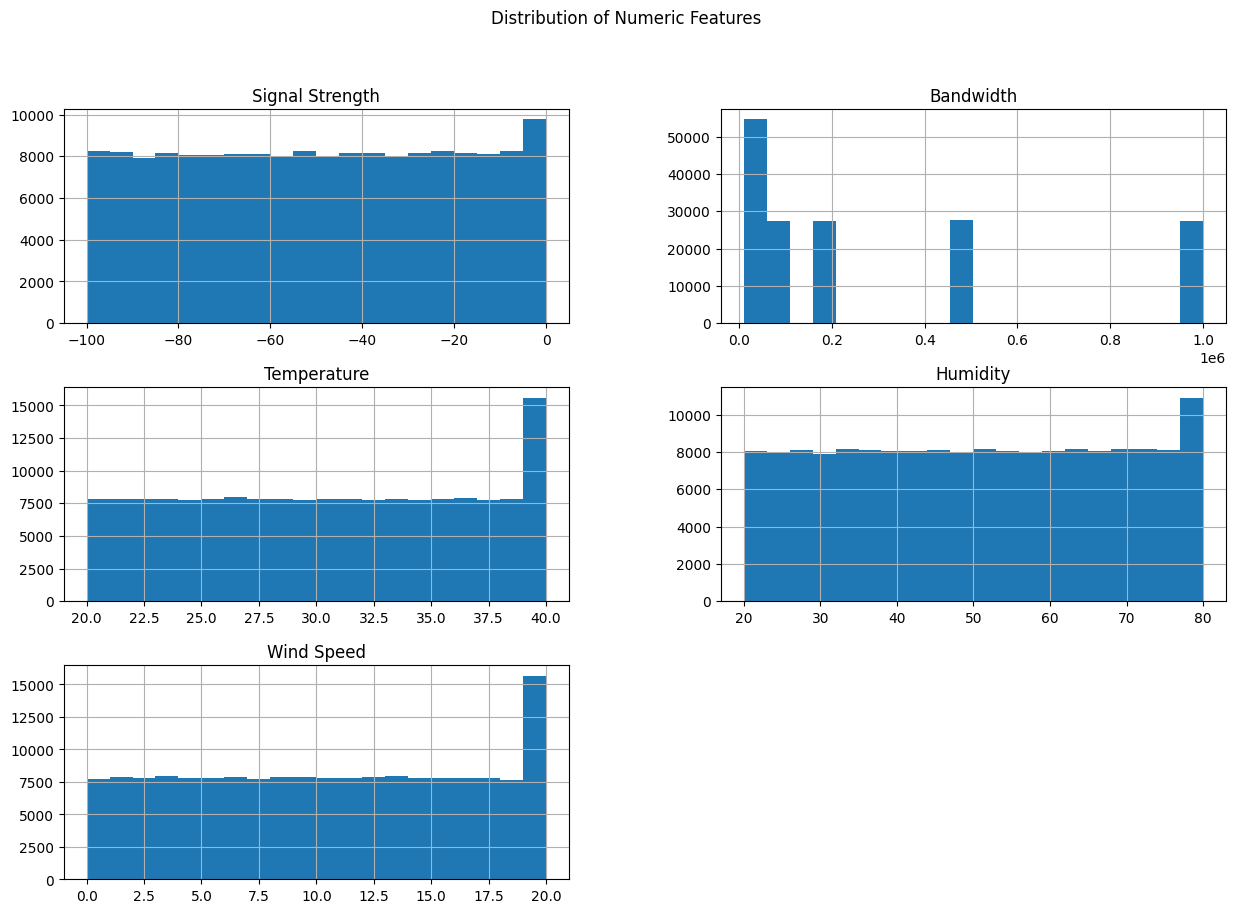

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = ['Signal Strength', 'Bandwidth', 'Temperature', 'Humidity', 'Wind Speed']
numeric_df = df.select(numeric_features).toPandas()
numeric_df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numeric Features")
plt.show()

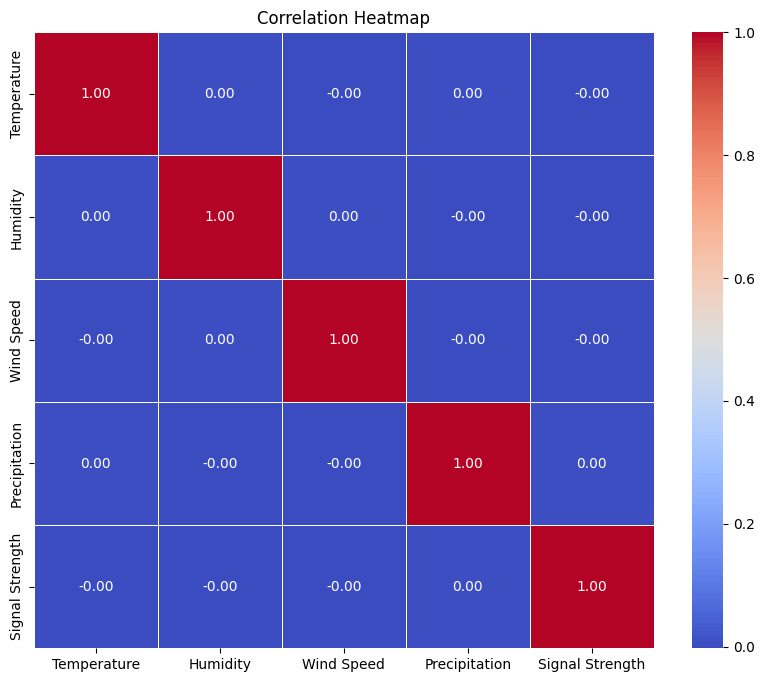

In [16]:
from pyspark.sql.functions import col


columns_for_heatmap = ["Temperature", "Humidity", "Wind Speed", "Precipitation", "Signal Strength"]

correlation_matrix = df.select(columns_for_heatmap).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()
